In [1]:
import pickle
import os
import time
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.decomposition import FastICA
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import nibabel as nib
import ants
from scipy.ndimage.morphology import binary_erosion
from scipy.ndimage.morphology import binary_dilation
import cv2
import bigbadbrain as bbb
import scipy
from scipy.interpolate import interp1d
from matplotlib.colors import ListedColormap
from matplotlib.pyplot import cm
import matplotlib.colors as mcolors
import matplotlib
import tqdm
import brainsss

/home/users/brezovec/.local/lib/python3.6/site-packages/ants/viz/render_surface_function.py:16: UserWarning: Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function
  "Cant import Plotly. Install it `pip install chart_studio` if you want to use ants.render_surface_function"


In [3]:
cluster_dir = "/oak/stanford/groups/trc/data/Brezovec/2P_Imaging/20221109_cluster_pca/"

In [4]:
### Load Supercluster Signals ###
file = os.path.join(cluster_dir, "20221202_SC_signals.npy")
supercluster_signals = np.load(file)
supercluster_signals.shape

(501, 30456)

In [5]:
file = os.path.join(cluster_dir,"20221122_behavior_fwd.npy")
beh_fwd = np.load(file)
print(beh_fwd.shape)

file = os.path.join(cluster_dir,"20221122_behavior_turn.npy")
beh_turn = np.load(file)
print(beh_turn.shape)

(30456,)
(30456,)


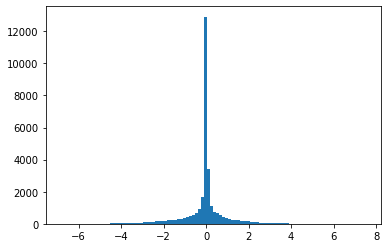

In [10]:
plt.hist(beh_turn,bins=100);

In [20]:
supercluster_signals_thresh.shape

(501, 3071)

(501, 3071)


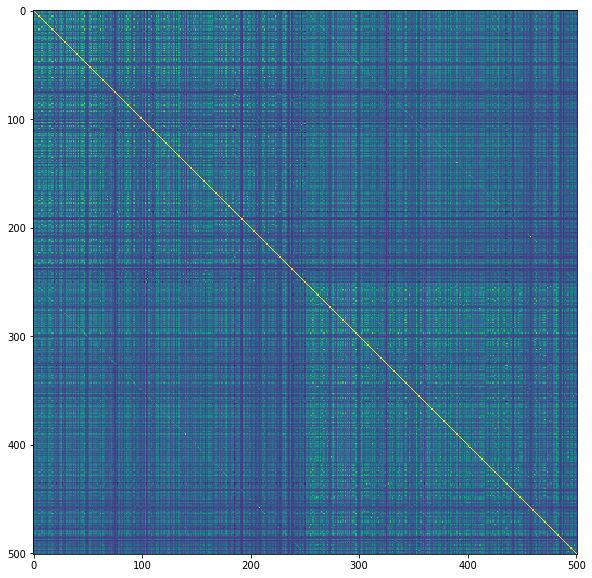

In [24]:
to_delete = np.where(beh_turn<0.75)[0]
supercluster_signals_thresh = np.delete(supercluster_signals,to_delete,axis=1)
print(supercluster_signals_thresh.shape)
corr_matrix_thresh = np.corrcoef(supercluster_signals_thresh)
plt.figure(figsize=(10,10))
plt.imshow(corr_matrix_thresh)

In [21]:
corr_matrix = np.corrcoef(supercluster_signals)
corr_matrix.shape

(501, 501)

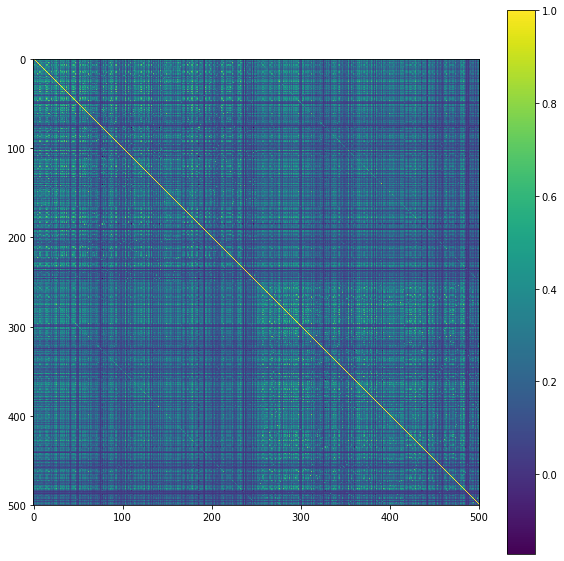

In [23]:
plt.figure(figsize=(10,10))
plt.imshow(corr_matrix)
plt.colorbar()

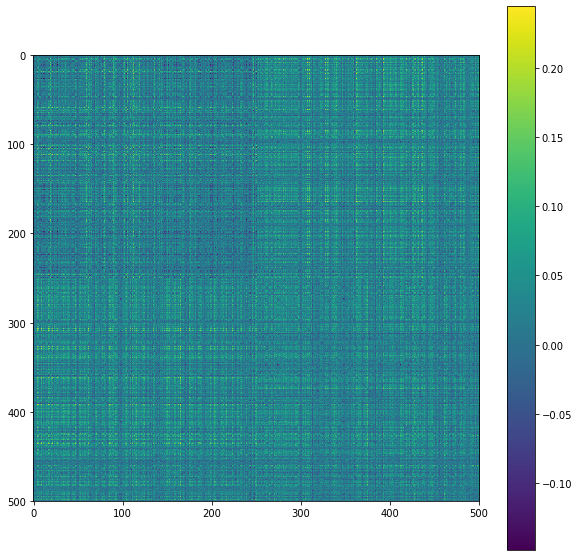

In [28]:
diff_matrix = corr_matrix-corr_matrix_thresh
plt.figure(figsize=(10,10))
plt.imshow(diff_matrix)
plt.colorbar()

In [30]:
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster
from scipy.cluster import hierarchy
from matplotlib import colors

In [98]:
to_delete = np.where(beh_turn<0.75)[0]
#to_delete = np.where(beh_turn>-0.75)[0]

supercluster_signals_thresh = np.delete(supercluster_signals,to_delete,axis=1)
print(supercluster_signals_thresh.shape)
corr_matrix_thresh = np.corrcoef(supercluster_signals_thresh)

### cluster based on one hemisphere (to keep the separate hemi blocks) ###
diff_matrix = corr_matrix-corr_matrix_thresh

(501, 3071)


In [99]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(diff_matrix)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.016416311264038086


In [100]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [101]:
n_clusters = 501

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

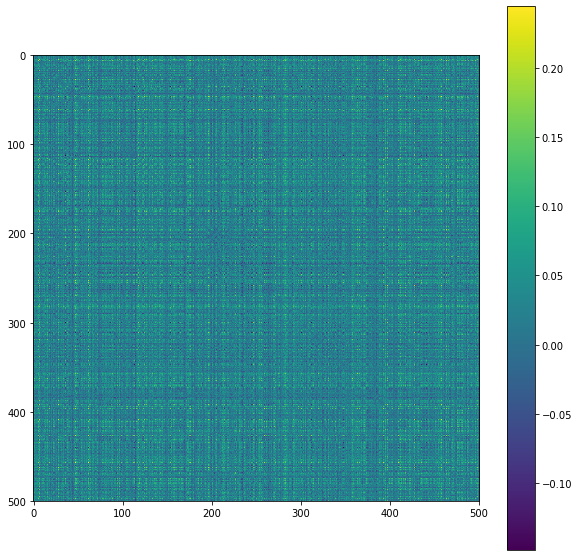

In [102]:
diff_matrix = corr_matrix-corr_matrix_thresh


plt.figure(figsize=(10,10))

diff_matrix = diff_matrix[cluster_ids,:]
diff_matrix = diff_matrix[:,cluster_ids]

plt.imshow(diff_matrix)
plt.colorbar()

(501, 501)
(501, 501)


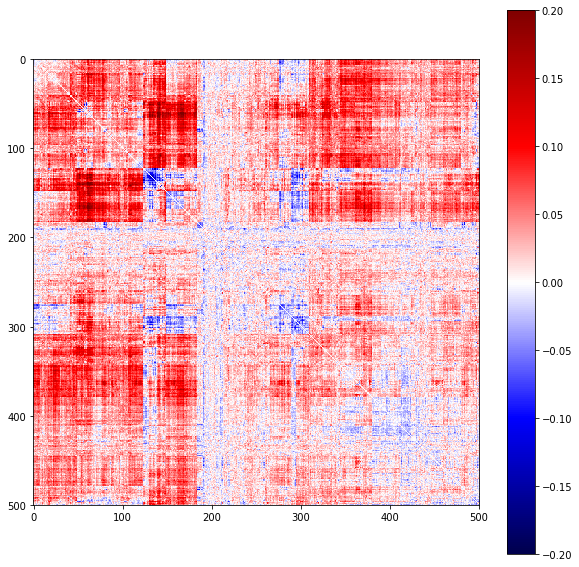

In [104]:
diff_matrix = corr_matrix-corr_matrix_thresh

### sort each axis
sorted_matrix = []
for i in range(501):
    sorted_matrix.extend(diff_matrix[np.where(cluster_ids==i)[0],:])
sorted_matrix = np.asarray(sorted_matrix)
print(sorted_matrix.shape)

sorted_matrix2 = []
for i in range(501):
    sorted_matrix2.extend(sorted_matrix[:,np.where(cluster_ids==i)[0]].T)
sorted_matrix2 = np.asarray(sorted_matrix2)
print(sorted_matrix2.shape)

plt.figure(figsize=(10,10))
plt.imshow(sorted_matrix2,cmap='seismic',vmin=-.2,vmax=.2)
plt.colorbar()

(501, 501)
(501, 501)


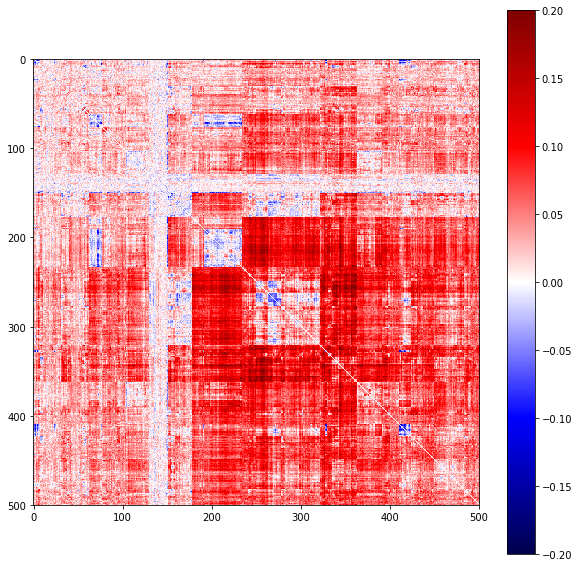

In [97]:
diff_matrix = corr_matrix-corr_matrix_thresh

### sort each axis
sorted_matrix = []
for i in range(501):
    sorted_matrix.extend(diff_matrix[np.where(cluster_ids==i)[0],:])
sorted_matrix = np.asarray(sorted_matrix)
print(sorted_matrix.shape)

sorted_matrix2 = []
for i in range(501):
    sorted_matrix2.extend(sorted_matrix[:,np.where(cluster_ids==i)[0]].T)
sorted_matrix2 = np.asarray(sorted_matrix2)
print(sorted_matrix2.shape)

plt.figure(figsize=(10,10))
plt.imshow(sorted_matrix2,cmap='seismic',vmin=-.2,vmax=.2)
plt.colorbar()

In [64]:
diff_matrix.shape

(501, 501)

In [74]:
diff_matrix[:250].shape, diff_matrix[251:].shape

((250, 501), (250, 501))

(501, 3071)
clustering.........
complete!
0.010986804962158203
(500, 501)
(500, 500)


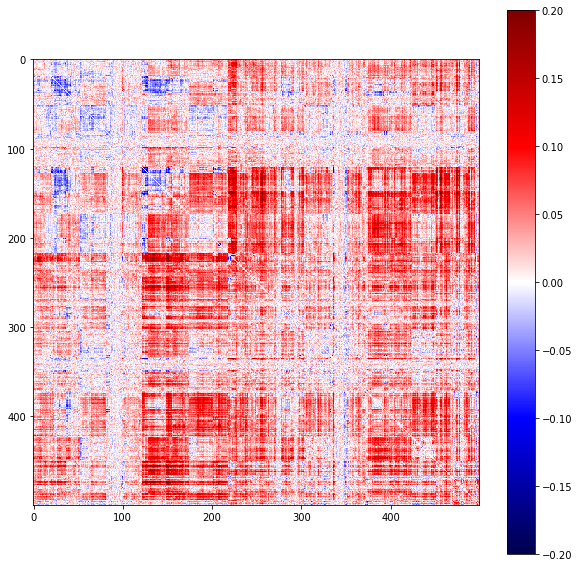

In [82]:
to_delete = np.where(beh_turn<0.75)[0]
supercluster_signals_thresh = np.delete(supercluster_signals,to_delete,axis=1)
print(supercluster_signals_thresh.shape)
corr_matrix_thresh = np.corrcoef(supercluster_signals_thresh)

### cluster based on one hemisphere (to keep the separate hemi blocks) ###
diff_matrix = corr_matrix-corr_matrix_thresh

t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(diff_matrix[:250,:])
print('complete!')
print(time.time()-t0)

### Create linkage matrix for dendrogram ###

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

#### GET CLUSTER IDS ###
n_clusters = 250

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

cluster_ids2 = cluster_ids+250
cluster_ids_hemi_double = np.concatenate((cluster_ids,cluster_ids2))

diff_matrix = corr_matrix-corr_matrix_thresh

### sort each axis
sorted_matrix = []
for i in range(500):
    sorted_matrix.extend(diff_matrix[np.where(cluster_ids_hemi_double==i)[0],:])
sorted_matrix = np.asarray(sorted_matrix)
print(sorted_matrix.shape)

sorted_matrix2 = []
for i in range(500):
    sorted_matrix2.extend(sorted_matrix[:,np.where(cluster_ids_hemi_double==i)[0]].T)
sorted_matrix2 = np.asarray(sorted_matrix2)
print(sorted_matrix2.shape)

plt.figure(figsize=(10,10))
plt.imshow(sorted_matrix2,cmap='seismic',vmin=-.2,vmax=.2)
plt.colorbar()

(501, 3956)
clustering.........
complete!
0.02547001838684082
(500, 501)
(500, 500)


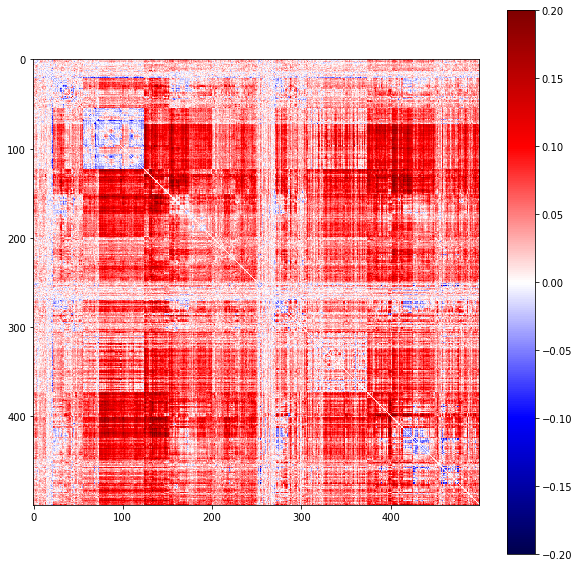

In [83]:
to_delete = np.where(beh_turn>-0.75)[0]
supercluster_signals_thresh = np.delete(supercluster_signals,to_delete,axis=1)
print(supercluster_signals_thresh.shape)
corr_matrix_thresh = np.corrcoef(supercluster_signals_thresh)

### cluster based on one hemisphere (to keep the separate hemi blocks) ###
diff_matrix = corr_matrix-corr_matrix_thresh

t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(diff_matrix[:250,:])
print('complete!')
print(time.time()-t0)

### Create linkage matrix for dendrogram ###

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

#### GET CLUSTER IDS ###
n_clusters = 250

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

cluster_ids2 = cluster_ids+250
cluster_ids_hemi_double = np.concatenate((cluster_ids,cluster_ids2))

diff_matrix = corr_matrix-corr_matrix_thresh

### sort each axis
sorted_matrix = []
for i in range(500):
    sorted_matrix.extend(diff_matrix[np.where(cluster_ids_hemi_double==i)[0],:])
sorted_matrix = np.asarray(sorted_matrix)
print(sorted_matrix.shape)

sorted_matrix2 = []
for i in range(500):
    sorted_matrix2.extend(sorted_matrix[:,np.where(cluster_ids_hemi_double==i)[0]].T)
sorted_matrix2 = np.asarray(sorted_matrix2)
print(sorted_matrix2.shape)

plt.figure(figsize=(10,10))
plt.imshow(sorted_matrix2,cmap='seismic',vmin=-.2,vmax=.2)
plt.colorbar()

# visualize clusters on brain

In [111]:
file = os.path.join(cluster_dir, 'superclusters_more.npy')
superclusters = np.load(file)
#with 249 there will be clusters 1-250 inclusive (len=250). cluster 140 is background
superclusters_250 = superclusters[:,:,:,249]
# right brain gets +250 to cluster ID so now 500 clusters
superclusters_250[157:,:,:] += 250

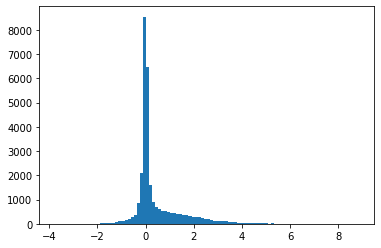

In [137]:
plt.hist(beh_fwd,bins=100);

In [138]:
to_delete = np.where(beh_turn<0.75)[0]
to_delete = np.where(beh_fwd<0.75)[0]

#to_delete = np.where(beh_turn>-0.75)[0]

supercluster_signals_thresh = np.delete(supercluster_signals,to_delete,axis=1)
print(supercluster_signals_thresh.shape)
corr_matrix_thresh = np.corrcoef(supercluster_signals_thresh)

### cluster based on one hemisphere (to keep the separate hemi blocks) ###
diff_matrix = corr_matrix-corr_matrix_thresh

(501, 6736)


In [139]:
t0 = time.time()
print('clustering.........')
model = AgglomerativeClustering(distance_threshold=0, #first run with =0. Then change to None
                                n_clusters=None, #and with n_clusters =None. Then change to n_clusters
                                memory=cluster_dir,
                                linkage='ward')
model = model.fit(diff_matrix)
print('complete!')
print(time.time()-t0)

clustering.........
complete!
0.05362439155578613


In [140]:
### Create linkage matrix for dendrogram

counts = np.zeros(model.children_.shape[0])
n_samples = len(model.labels_)
for i, merge in enumerate(model.children_):
    current_count = 0
    for child_idx in merge:
        if child_idx < n_samples:
            current_count += 1  # leaf node
        else:
            current_count += counts[child_idx - n_samples]
    counts[i] = current_count

linkage_matrix = np.column_stack([model.children_, model.distances_,
                                  counts]).astype(float)

In [141]:
n_clusters = 20

### Given a desired # of clusters, grab the distance threshold - needed for dendrogram
thresh = model.distances_[-n_clusters+1]

### Create the same # of colors as # of clusters
custom_cmap = cm.gist_ncar(np.linspace(0.1, 0.95, n_clusters))
cluster_colors = [colors.rgb2hex(rgb[:3]) for rgb in custom_cmap]
hierarchy.set_link_color_palette(cluster_colors[::-1])

### Grab the cluster ids
cluster_ids = fcluster(linkage_matrix, t=n_clusters, criterion='maxclust')
cluster_ids -= 1 #make 0 index

cluster_colors_for_brain = cluster_colors[:]
#cluster_colors_for_brain.insert(0,'grey')
cmap = colors.ListedColormap(cluster_colors_for_brain)

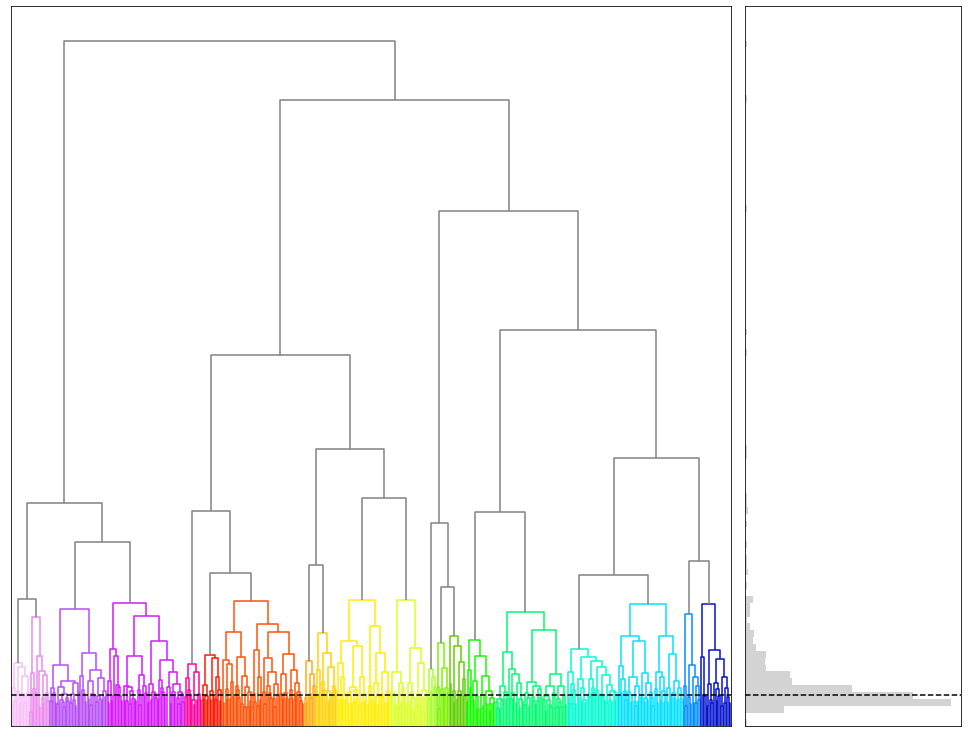

In [142]:
fig = plt.figure(figsize=(10,10))
background_color = '#D3D3D3'

ax_dendrogram = fig.add_axes([1.1, 0, 1, 1])
ax_dendrogram.get_xaxis().set_visible(False)
ax_dendrogram.get_yaxis().set_visible(False)
dendrogram(linkage_matrix,
           truncate_mode=None,
           p=0,
           color_threshold=thresh,
           no_labels=True,
           distance_sort=True,
           above_threshold_color='grey');
try:
    plt.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')

ax_dend_hist = fig.add_axes([2.12, 0, .3, 1],sharey=ax_dendrogram)
ax_dend_hist.hist(linkage_matrix[:,2],bins=100,orientation='horizontal',color=background_color);
try:
    ax_dend_hist.axhline(linkage_matrix[251-n_clusters,2],color='k',linestyle='--')
except:
    print('axhline failed')
ax_dend_hist.get_xaxis().set_visible(False)
ax_dend_hist.get_yaxis().set_visible(False)

In [143]:
visulize_clusters = np.zeros((314, 146, 91, 4)) # last axis is for color
visulize_clusters[:] = np.nan
for cluster in range(501):
    visulize_clusters[np.where(superclusters_250==cluster)] = custom_cmap[cluster_ids[cluster],:]

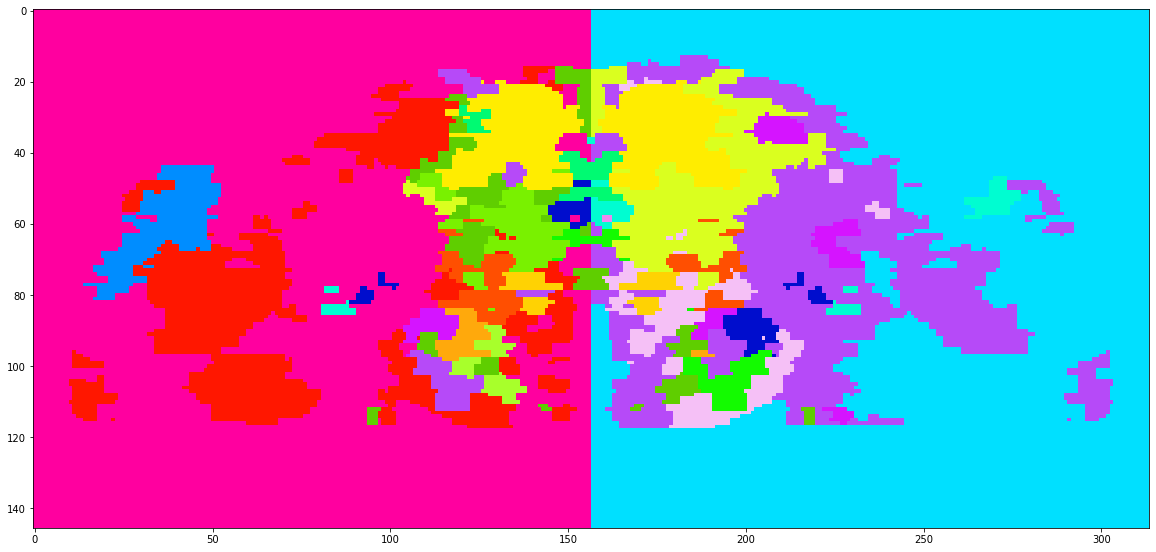

In [153]:
plt.figure(figsize=(20,20))
z=40
plt.imshow(np.swapaxes(visulize_clusters[:,:,z,:],0,1))

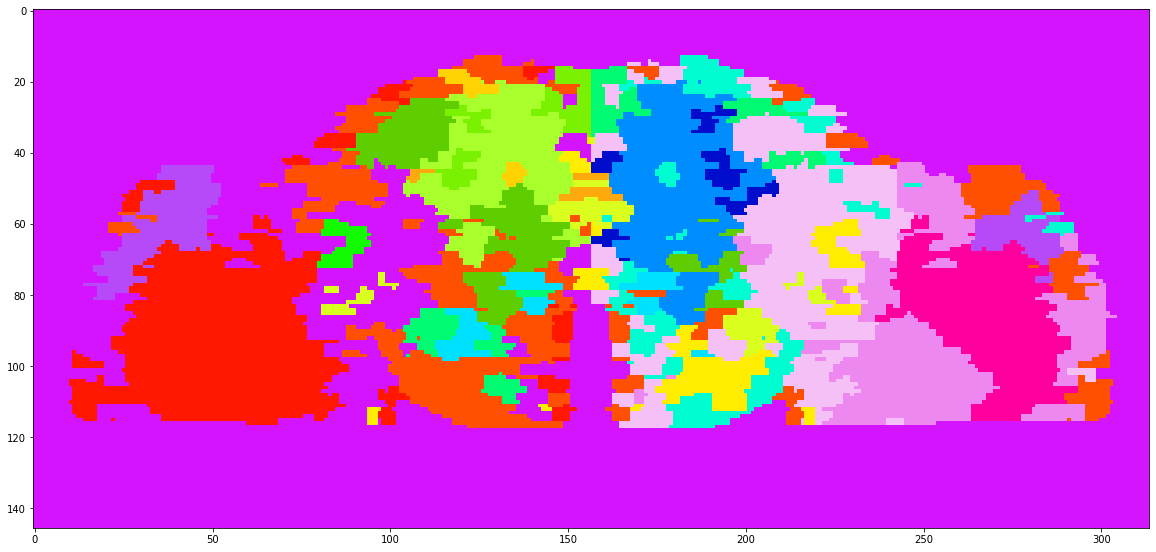

In [134]:
plt.figure(figsize=(20,20))
z=40
plt.imshow(np.swapaxes(visulize_clusters[:,:,z,:],0,1))

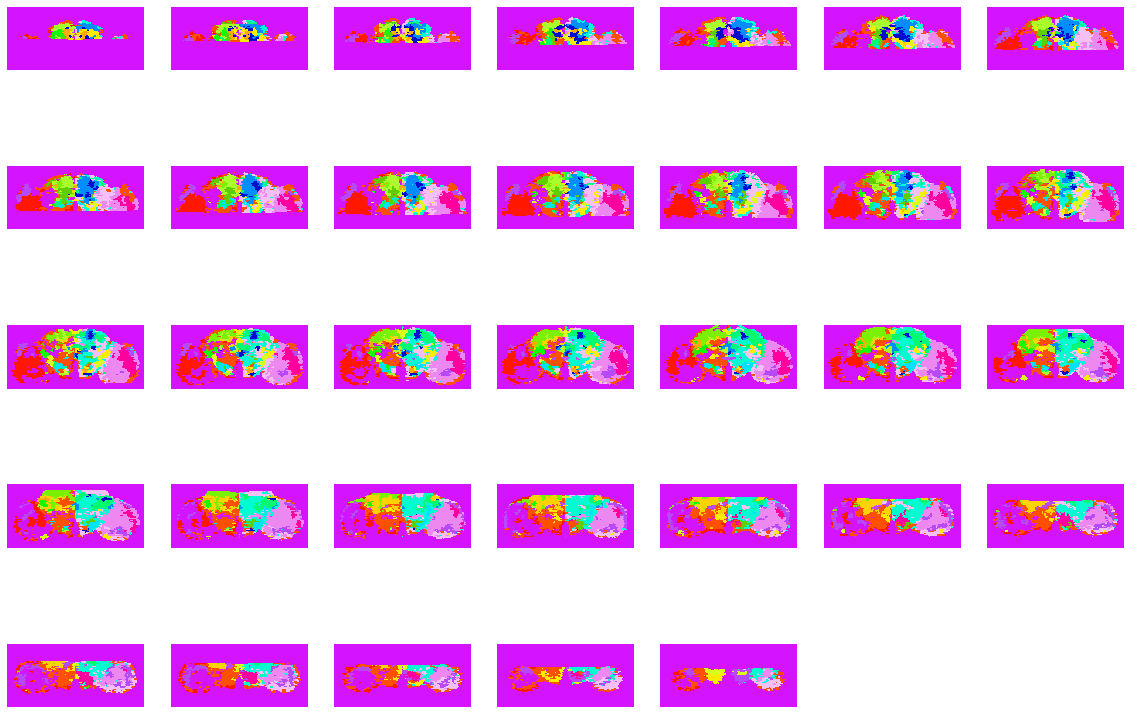

In [128]:
plt.figure(figsize=(20,20))
for j,z in enumerate(range(20,85,2)):
    plt.subplot(7,7,j+1)
    plt.imshow(np.swapaxes(visulize_clusters[:,:,z,:],0,1))
    plt.axis('off')